In [1]:
%load_ext autoreload
%autoreload 2

In [144]:
from operator import itemgetter
import warnings

import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

from allen_v1dd.client import EMClient
from allen_v1dd import plotting

import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

In [135]:
em_client = EMClient.init_microns()

In [136]:
# LAYER_BOUNDARIES = [100, 375, 550, 750, 800]
# LAYER_BOUNDARIES = [90, 255, 380, 550, 700]
# LAYER_BOUNDARIES = [106.80615154, 276.21908419, 411.8631847 , 552.04973966, 768.58049474]
# LAYER_NAMES = ["2/3", "4", "5", "6"]

def add_layer_lines(ax):
    transform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)

    for layer, (depth_min, depth_max) in em_client.layer_boundaries.items():
        depth_mid = (depth_min + depth_max) / 2 if np.isfinite(depth_min) else depth_max - 50
        ax.axhline(depth_max, xmin=0.02, xmax=0.98, color="red", linestyle="dashed")
        ax.text(x=1, y=depth_max, s=f"{depth_max:.0f} µm", ha="left", va="center", color="red", fontsize=10, transform=transform)
        ax.text(x=1, y=depth_mid, s=f"L{layer}", ha="left", va="center", color="darkred", fontweight="bold", transform=transform)

def is_in_layer(pos, layer, boundary_padding=0):
    min_depth, max_depth = em_client.layer_boundaries[layer]
    min_depth -= boundary_padding
    max_depth += boundary_padding

    if isinstance(pos, pd.Series):
        return pos.apply(lambda p: min_depth <= p[1] <= max_depth)
    elif isinstance(pos, np.ndarray) and len(pos.shape) == 2:
        return (min_depth <= pos[:,1]) & (pos[:,1] <= max_depth)
    else:
        return min_depth <= pos[1] <= max_depth

def is_in_central_column(pos):
    return 575 <= pos[0] <= 750 and 775 <= pos[2] <= 950

In [6]:
nucleus_neuron_svm = em_client.query_table("nucleus_neuron_svm")

Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.


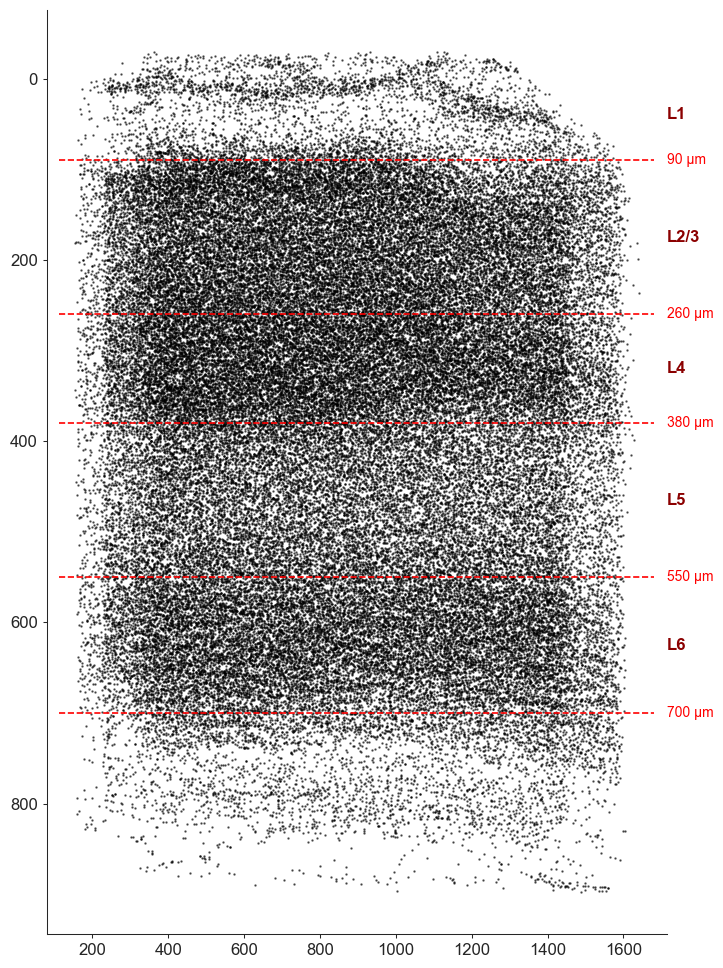

In [137]:
neuron_pos_nm = np.vstack(nucleus_neuron_svm.pt_position.values[nucleus_neuron_svm.cell_type == "neuron"])
neuron_pos_microns = em_client.transform_position_to_microns(neuron_pos_nm)

fig, ax = plt.subplots(figsize=(8, 12))
ax.scatter(neuron_pos_microns[:, 0], neuron_pos_microns[:, 1], s=1, color="black", alpha=0.5)
# ax.scatter(neuron_pos_nm[:, 0], neuron_pos_nm[:, 1], s=1, color="black", alpha=0.5)
ax.invert_yaxis()
add_layer_lines(ax)

In [14]:
proof_table = em_client.query_table("proofreading_status_public_release")
axo_proof_pt_root_ids = proof_table.pt_root_id.values[proof_table.status_axon.isin(["extended"])]
den_proof_pt_root_ids = proof_table.pt_root_id.values[proof_table.status_dendrite.isin(["clean", "extended"])]
proof_pt_root_ids = np.intersect1d(axo_proof_pt_root_ids, den_proof_pt_root_ids)

proof_table.head()

id valid   pt_supervoxel_id          pt_root_id            valid_id  \
0   4     t  91077153340676495  864691135355207375  864691135355207375   
1   7     t  91570559116360958  864691136602027473  864691136602027473   
2   8     t  90444453118345856  864691135866846742  864691135866846742   
3   9     t  89741246779911895  864691135445832338  864691135445832338   
4  13     t  91499640750531825  864691135569255558  864691135569255558   

  status_dendrite status_axon                     pt_position  
0        extended         non  [765696.0, 839552.0, 913800.0]  
1        extended         non  [779456.0, 864512.0, 888200.0]  
2        extended         non  [747072.0, 857152.0, 912440.0]  
3        extended         non  [725248.0, 871616.0, 930040.0]  
4        extended         non  [776448.0, 848256.0, 927000.0]

In [16]:
soma_df = em_client.query_table("aibs_soma_nuc_metamodel_preds_v117")
soma_df = soma_df.drop_duplicates("pt_root_id", keep=False)
# soma_df["pt_position_microns"] = nm_transform.apply_(soma_df["pt_position"])
soma_df["pt_position_microns"] = em_client.transform_position_to_microns(soma_df["pt_position"])
soma_df

id valid  target_id classification_system  cell_type  id_ref  \
1       4509     t     487329         aibs_neuronal         MC  487329   
2       4693     t     106662         aibs_neuronal        23P  106662   
3       5061     t     271350         aibs_neuronal      6P-CT  271350   
4       8652     t     456040         aibs_neuronal         MC  456040   
5       8744     t     407408         aibs_neuronal      6P-CT  407408   
...      ...   ...        ...                   ...        ...     ...   
86910  86911     t     394515      aibs_nonneuronal  astrocyte  394515   
86912  86913     t     329229         aibs_neuronal         4P  329229   
86913  86914     t     589184      aibs_nonneuronal      oligo  589184   
86914  86915     t     256280         aibs_neuronal        23P  256280   
86915  86916     t     258113         aibs_neuronal        23P  258113   

      valid_ref      volume    pt_supervoxel_id          pt_root_id  \
1             t  295.937638  105279407463397326  864691135975935434   
2             t  230.148178   79524515478544304  864691136084076652   
3             t  305.328128   87351114324194368  864691135937342005   
4             t  257.463910  101129507251445952  864691136084057196   
5             t  244.599357   96711325195350282  864691134917402634   
...         ...         ...                 ...                 ...   
86910         t  190.166303   96347181023422242  864691136050803443   
86912         t  271.882322   92547130727975969  864691135740183915   
86913         t  124.472852  110987178548578816  864691135081676023   
86914         t  354.738012   87546415009833381  864691136966016974   
86915         t  355.082076   88181726572292650  864691135785513412   

                           pt_position bb_start_position  bb_end_position  \
1      [1178176.0, 474496.0, 869800.0]   [nan, nan, nan]  [nan, nan, nan]   
2       [428224.0, 476992.0, 776560.0]   [nan, nan, nan]  [nan, nan, nan]   
3       [655680.0, 943872.0, 835000.0]   [nan, nan, nan]  [nan, nan, nan]   
4      [1058176.0, 530112.0, 959520.0]   [nan, nan, nan]  [nan, nan, nan]   
5       [929600.0, 978432.0, 729680.0]   [nan, nan, nan]  [nan, nan, nan]   
...                                ...               ...              ...   
86910   [918016.0, 611264.0, 823840.0]   [nan, nan, nan]  [nan, nan, nan]   
86912   [808704.0, 607040.0, 626400.0]   [nan, nan, nan]  [nan, nan, nan]   
86913  [1343680.0, 710784.0, 885360.0]   [nan, nan, nan]  [nan, nan, nan]   
86914   [663232.0, 473024.0, 807920.0]   [nan, nan, nan]  [nan, nan, nan]   
86915   [681280.0, 531968.0, 809000.0]   [nan, nan, nan]  [nan, nan, nan]   

                                     pt_position_microns  
1      [1132.3376333081478, 178.7041716229213, 869.80...  
2      [385.0218863509487, 115.82805000426656, 776.56...  
3      [570.9210744260782, 600.755527271752, 835.0000...  
4      [1007.9470157484845, 223.64984682227282, 959.5...  
5      [840.7866236580102, 659.0577170912412, 729.680...  
...                                                  ...  
86910  [861.2475040284874, 292.2772900583024, 823.840...  
86912  [752.7196150480487, 278.54219510233094, 626.40...  
86913  [1276.6179844787655, 428.51764849333216, 885.3...  
86914  [619.4814439473164, 132.35744623388018, 807.92...  
86915  [632.3234577579583, 192.65013336330972, 809.00...  

[77625 rows x 14 columns]

In [17]:
soma_df.cell_type.value_counts()

23P          17091
4P           12812
6P-IT         9831
5P-IT         8395
astrocyte     6275
6P-CT         5243
oligo         4816
BC            2862
microglia     2523
MC            2156
OPC           1443
5P-ET         1363
BPC           1361
NGC            570
pericyte       457
5P-NP          427
Name: cell_type, dtype: int64

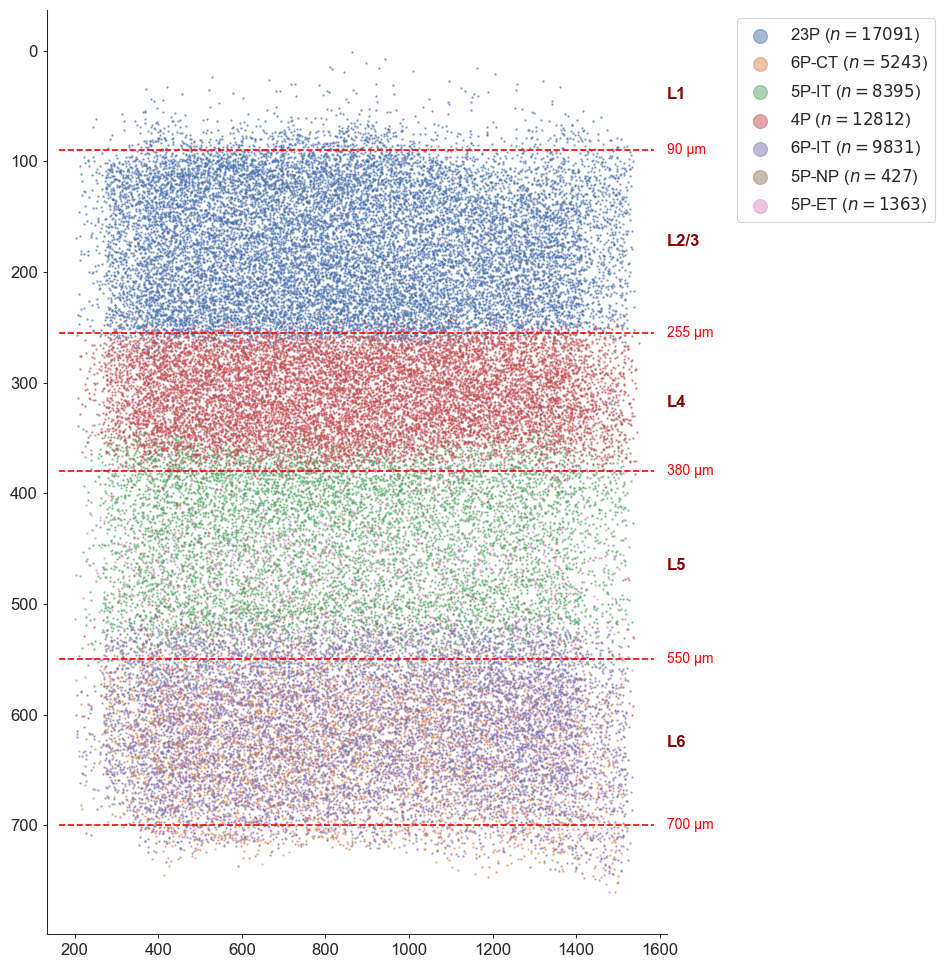

In [19]:
fig, ax = plt.subplots(figsize=(8, 12))

for cell_type in soma_df.cell_type.unique():
    if cell_type not in em_client.exc_cell_types: continue
    pos = soma_df.pt_position_microns[soma_df.cell_type == cell_type]
    x = pos.apply(itemgetter(0))
    y = pos.apply(itemgetter(1))
    ax.scatter(x, y, label=f"{cell_type} ($n = {len(pos)}$)", s=1, alpha=0.5)

ax.legend(loc="upper left", bbox_to_anchor=(1.1, 1), bbox_transform=ax.transAxes, markerscale=10)
ax.invert_yaxis()
add_layer_lines(ax)

In [20]:
root_id_to_cell_type = pd.Series(index=soma_df.pt_root_id.values, data=soma_df.cell_type.values)
root_id_to_soma_pos = pd.Series(index=soma_df.pt_root_id.values, data=soma_df.pt_position_microns.values)

# Estimate connection probabilities based on all somas

In [22]:
def matches_or_in(series, val):
    if type(val) is str:
        return series == val
    else:
        return series.isin(val)

def get_cell_type_str(cell_type):
    if cell_type == em_client.exc_cell_types:
        return "E"
    elif cell_type == em_client.inh_cell_types:
        return "I"
    elif type(cell_type) is not str:
        return str(cell_type)
    else:
        return cell_type

In [23]:
is_neuron = is_neuron = soma_df.classification_system == "aibs_neuronal"
l_23 = is_in_layer(soma_df.pt_position_microns, "2/3") & is_neuron
np.sum(l_23 & matches_or_in(soma_df.cell_type, em_client.exc_cell_types)) / np.sum(l_23)

0.8968395945140131

In [441]:
syn_cache = {}

def get_axo_syn(pre_root_ids):
    key = str(list(pre_root_ids))
    if key in syn_cache:
        return syn_cache[key]
    else:
        syn = em_client.get_axonal_synapses(pre_root_ids)
        syn_cache[key] = syn
        return syn

# L2/3 MC = 7
# L2/3 BC = 12
# L2/3 BPC = 12
# L2/3 E = 6
# L4 MC = 9
# L4 BC = 13
# L4 BPC = 11
# L4 E = 3
# L5 MC = 16
# L5 BC = 25
# L5 BPC = 4
# L5 E = 22
# L6 MC = 7
# L6 BC = 8
# L6 BPC = 5
# L6 E = 4


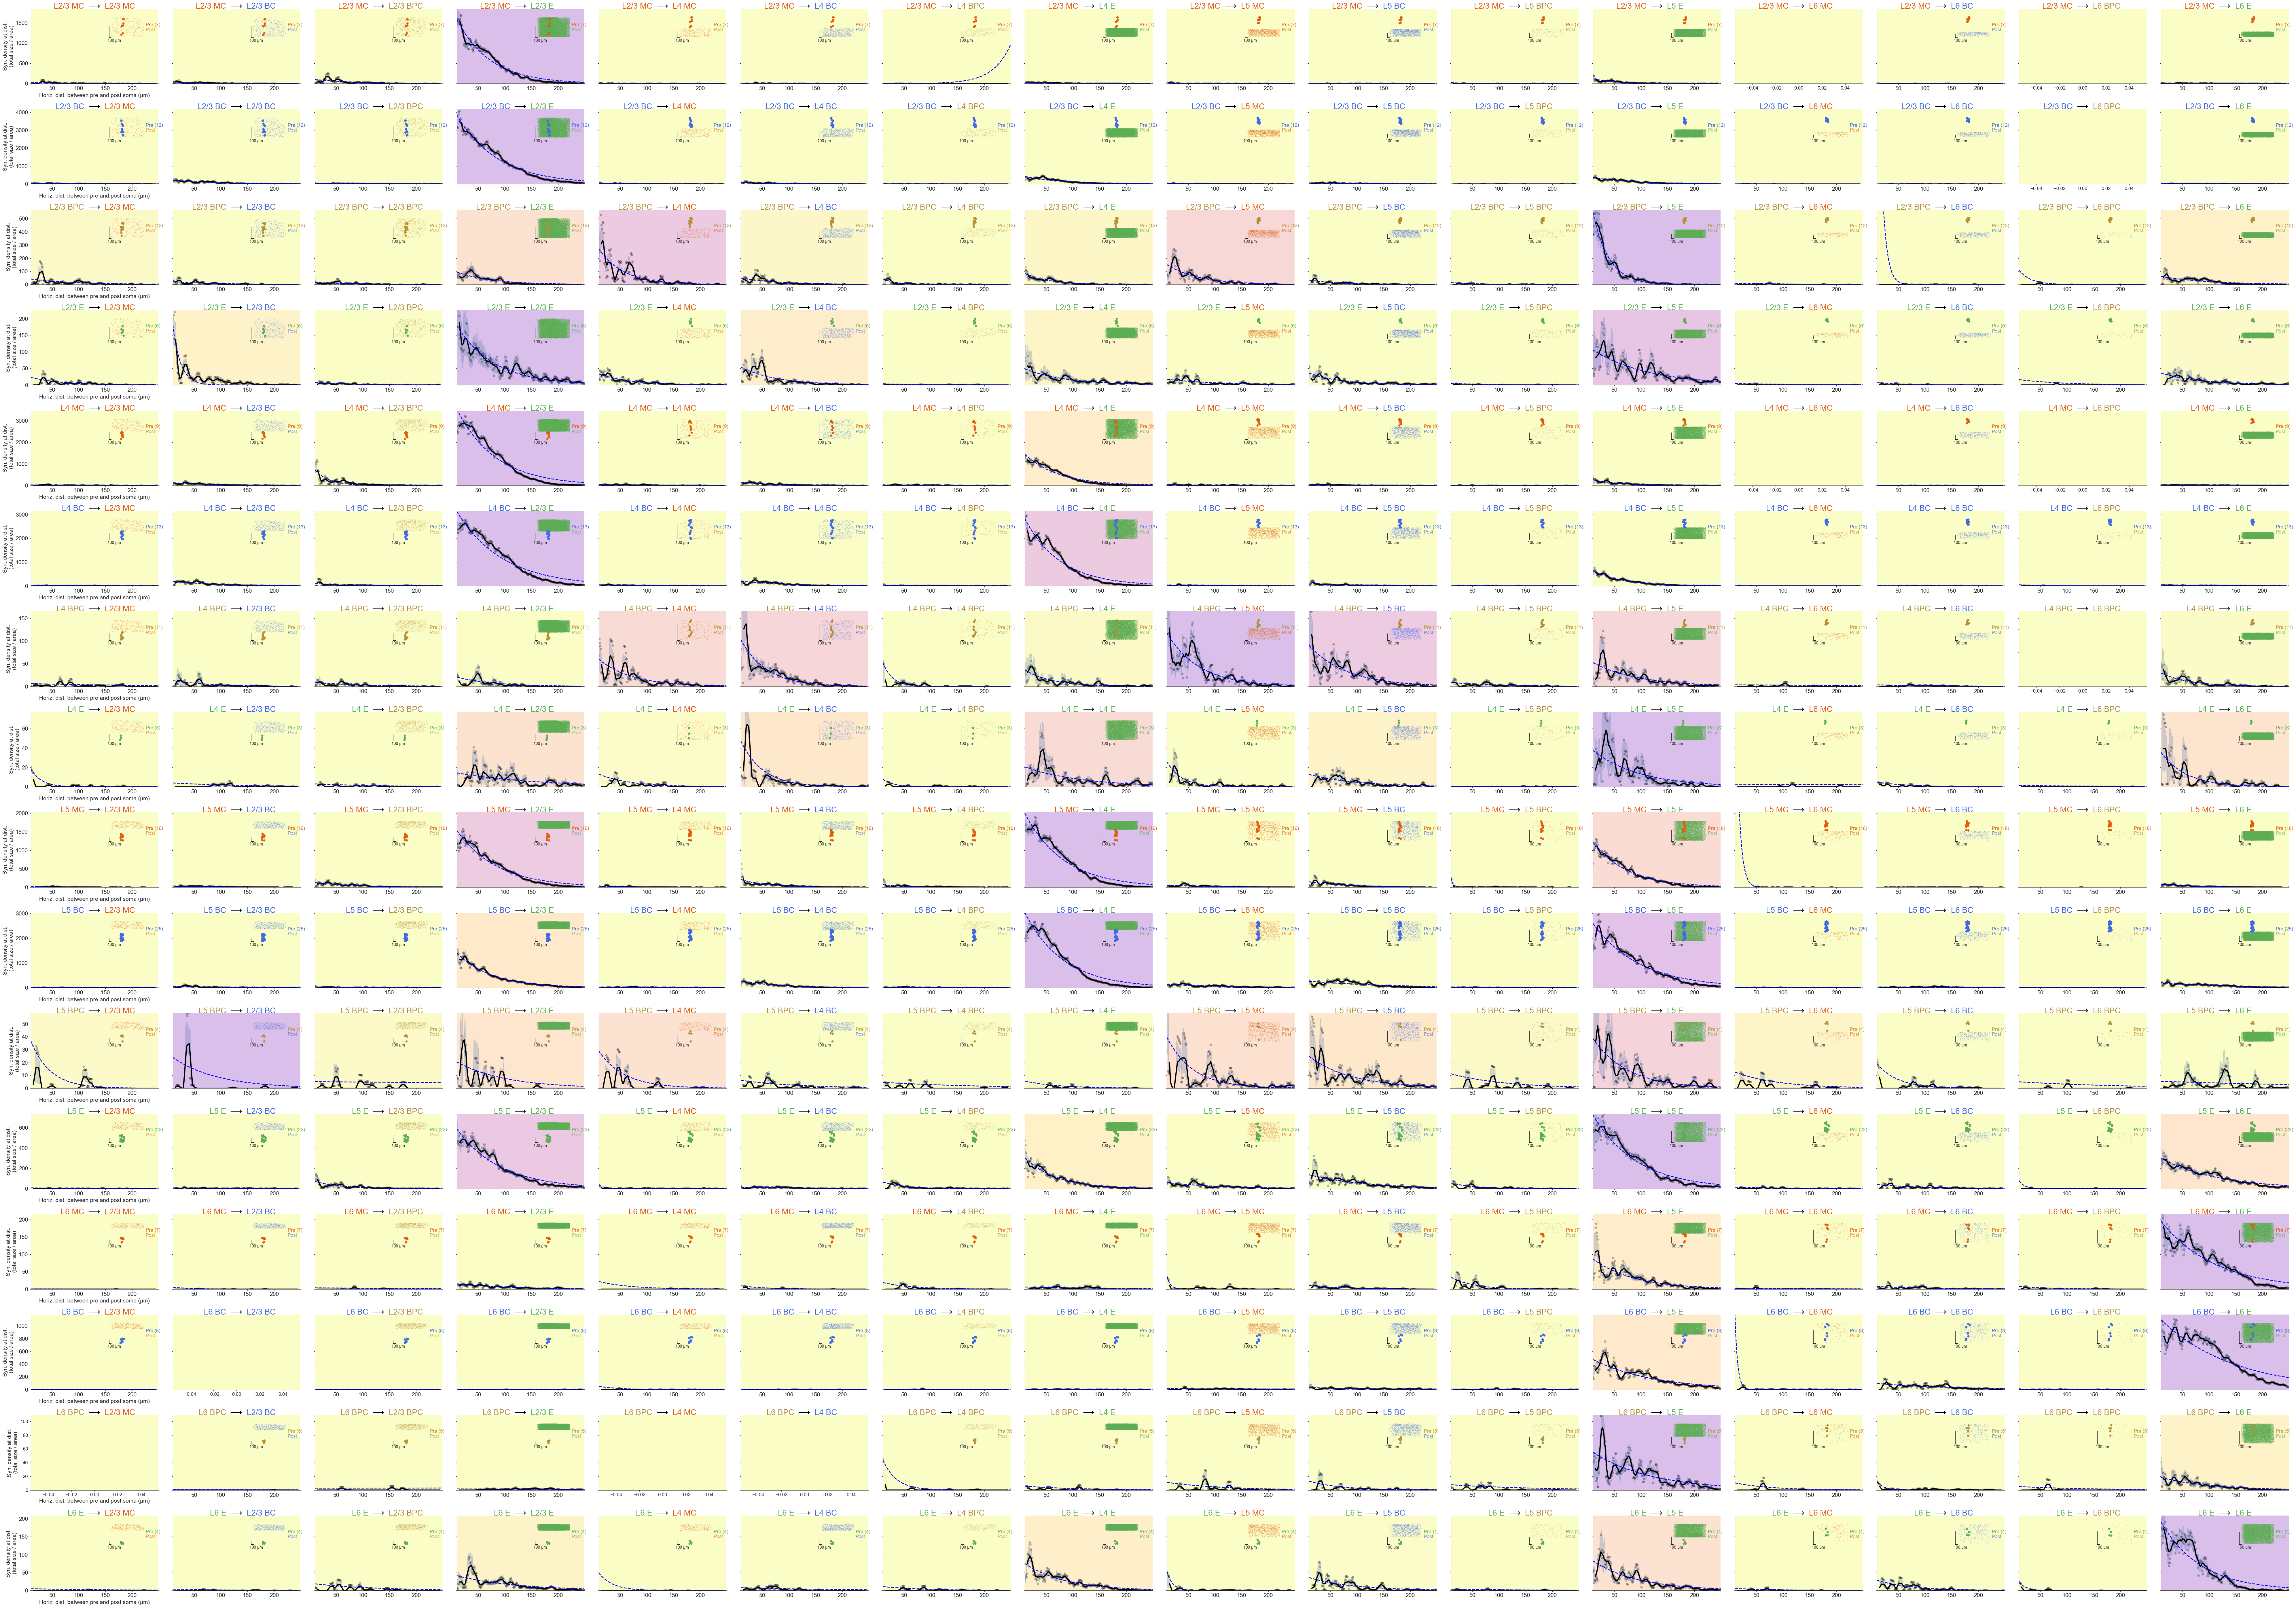

In [484]:
cell_types_no_layer = [
    ("MC", plotting.MC_COLOR),
    ("BC", plotting.BC_COLOR),
    ("BPC", plotting.BPC_COLOR),
    (em_client.exc_cell_types, plotting.EXC_COLOR),
]
layers = ["2/3", "4", "5", "6"]
# layers = ["2/3"]

cell_types = []

for layer in layers:
    for c in cell_types_no_layer:
        cell_types.append((*c, layer))

dist_range = np.arange(10, 250)
# dist_window_radius = 0.5 # microns
dist_window_radius = 3
dist_annuli_areas = np.pi * (np.square(dist_range + dist_window_radius) - np.square(dist_range - dist_window_radius))
n_boot = 1000
confidence_interval = 0.95

fig, axs = plt.subplots(figsize=(5*len(cell_types), 3.5*len(cell_types)), nrows=len(cell_types), ncols=len(cell_types))

avg_local_conn_str = np.zeros_like(axs, dtype=float) # used for plot backgrounds

for row_i in range(len(cell_types)):
    pre_cell_type, pre_color, pre_layer = cell_types[row_i]

    pre_population_soma_df_mask = matches_or_in(soma_df.cell_type, pre_cell_type) \
                                    & is_in_layer(soma_df.pt_position_microns, pre_layer) \
                                    & soma_df.pt_root_id.isin(axo_proof_pt_root_ids) \
                                    & soma_df.pt_position_microns.apply(is_in_central_column)

    n_pre = int(pre_population_soma_df_mask.sum())
    print(f"# L{pre_layer} {get_cell_type_str(pre_cell_type)} = {n_pre}")

    pre_root_ids = soma_df.pt_root_id.values[pre_population_soma_df_mask]
    all_axo_syn = get_axo_syn(pre_root_ids)

    for col_i in range(len(cell_types)):
        post_cell_type, post_color, post_layer = cell_types[col_i]
        ax = axs[row_i, col_i]

        post_population_soma_df_mask = matches_or_in(soma_df.cell_type, post_cell_type) \
                                        & is_in_layer(soma_df.pt_position_microns, post_layer)
                                        # & soma_df.pt_root_id.isin(den_proof_pt_root_ids) \

        post_population_root_ids = soma_df.pt_root_id.values[post_population_soma_df_mask]
        post_population_soma_pos = np.vstack(soma_df.pt_position_microns.values[post_population_soma_df_mask])

        title_kwargs = dict(va="baseline", fontsize=20, transform=ax.transAxes)
        mid = ax.text(x=0.5, y=1, s="$\longrightarrow$ ", color="black", ha="center", **title_kwargs) # space after seems to format better
        bb = mid.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = ax.transData.inverted().transform_bbox(bb)
        ax.text(x=bb.xmin, y=1, s=f"L{pre_layer} {get_cell_type_str(pre_cell_type)}", color=pre_color, ha="right", **title_kwargs)
        ax.text(x=bb.xmax, y=1, s=f"L{post_layer} {get_cell_type_str(post_cell_type)}", ha="left", color=post_color, **title_kwargs)

        if col_i == 0:
            ax.set_xlabel("Horiz. dist. between pre and post soma (µm)", fontsize=14)
            ax.set_ylabel("Syn. density at dist.\n(total size / area)", fontsize=14)

        syn_density_at_dist = np.full_like(dist_range, np.nan, dtype=float)
        soma_soma_horiz_dist = all_axo_syn.apply(lambda row: np.linalg.norm(row["pre_soma_position_microns"][::2] - row["post_soma_position_microns"][::2]) if row["post_soma_position_microns"] is not None else np.inf, axis=1)

        syn_mask = all_axo_syn.post_pt_root_id.isin(post_population_root_ids)
        syn_dist = soma_soma_horiz_dist.values[syn_mask]
        syn_size = all_axo_syn["size"].values[syn_mask]
        boot_dist = np.full((len(dist_range), n_boot), np.nan, dtype=float)

        for dist_i, dist in enumerate(dist_range):
            within_dist_mask = np.abs(syn_dist - dist) < dist_window_radius
            n_syn = int(within_dist_mask.sum())

            if n_syn == 0:
                # No synapses in range
                continue

            area = dist_annuli_areas[dist_i]
            sizes = syn_size[within_dist_mask]
            syn_density_at_dist[dist_i] = sizes.sum() / area

        # Bootstrap estimate
        boot_r = 5 # microns
        for dist_i, dist in enumerate(dist_range):
            within_dist_mask = np.abs(syn_dist - dist) < boot_r
            n_syn = int(within_dist_mask.sum())

            if n_syn == 0:
                # No synapses in range
                continue

            area = np.pi * ((dist+boot_r)**2 - (dist-boot_r)**2)
            sizes = syn_size[within_dist_mask]
            rand_indices = np.random.randint(low=0, high=n_syn, size=(n_boot, n_syn))
            boot_dist[dist_i, :] = sizes[rand_indices].sum(axis=1) / area



        # ax.scatter(dist_range, syn_density_at_dist, color="black", s=36, alpha=0.25) # doesn't work; wrong shapes
        # Compute rolling average
        rolling_avg_r = 5
        y_rolling_avg = np.full_like(dist_range, np.nan, dtype=float)
        kernel = np.ones(2*rolling_avg_r+1) / (2*rolling_avg_r+1) # Rolling average kernel
        # kernel = scipy.ndimage.gaussian_filter1d(np.array([0]*rolling_avg_r + [1] + [0]*rolling_avg_r, dtype=float), sigma=3) # Gaussian kernel

        for dist_i in range(rolling_avg_r, len(dist_range) - rolling_avg_r):
            rolling_avg_slice = slice(dist_i-rolling_avg_r, dist_i+rolling_avg_r+1)
            y_rolling_avg[dist_i] = np.nansum(syn_density_at_dist[rolling_avg_slice] * kernel)

        # Compute bootstrap CI
        # for dist_i, dist in enumerate(dist_range):
        #     r = dist_window_radius + rolling_avg_r
        #     syn_within_dist = all_axo_syn[(np.abs(soma_soma_horiz_dist - dist) < r) & (all_axo_syn.post_pt_root_id.isin(post_population_root_ids))]
            
        #     if len(syn_within_dist) > 0:
        #         # area = np.pi * ((dist+r)**2 - (dist-r)**2)
        #         area = dist_annuli_areas[dist_i]
        #         sizes = syn_within_dist["size"].values
        #         rand_indices = np.random.randint(low=0, high=len(syn_within_dist), size=(n_boot, len(syn_within_dist)))
        #         boot_dist[dist_i, :] = sizes[rand_indices].sum(axis=1) / area

        # Scatter all points
        ax.scatter(dist_range, syn_density_at_dist, color="black", s=25, alpha=0.25)

        # Curve fit
        def fit_fn(x, a, k):
            # return a * np.exp(k * x) + c
            return a * np.exp(k * x)

        def fit_exp_nonlinear(x, y):
            opt_params, _ = scipy.optimize.curve_fit(fit_fn, x, y, maxfev=1000)
            return opt_params

        def fit_exp_linear(x, y, c=None):
            if c is None:
                if y.min() <= 0:
                    c = y.min() - 10
                else:
                    c = 0
            y = y - c
            y = np.log(y)
            k, log_a = np.polyfit(x, y, 1)
            a = np.exp(log_a)
            return a, k

        not_na_mask = ~np.isnan(syn_density_at_dist)
        x = dist_range[not_na_mask]
        y = syn_density_at_dist[not_na_mask]

        if len(x) < 3:
            continue

        init_guess = fit_exp_linear(x, y)
        fit_params, _ = scipy.optimize.curve_fit(fit_fn, x, y, maxfev=2000, p0=init_guess)

        # Plot rolling average
        ax.plot(dist_range, y_rolling_avg, color="black", linewidth=3, linestyle="solid")

        # Plot bootstrap mean
        # ax.plot(dist_range, boot_dist.mean(axis=1), color="red", linewidth=2, linestyle="dashed")

        # Plot curve fit
        ax.plot(dist_range, fit_fn(dist_range, *fit_params), color="blue", linewidth=2, linestyle="dashed")

        # Plot bootstrap CI
        quantile_low = (1-confidence_interval) / 2
        boot_low, boot_high = np.quantile(boot_dist, (quantile_low, 1-quantile_low), axis=1)
        ax.fill_between(dist_range, boot_low, boot_high, color="b", alpha=0.25)

        ax.set_xlim(dist_range.min(), dist_range.max())
        ax.set_ylim(0, np.nanmax(y_rolling_avg) * 1.2)
        ax.tick_params(axis="both", labelsize=14)

        # Save avg conn str
        local_strs = syn_density_at_dist[(25 <= dist_range) & (dist_range <= 100)]
        local_strs = local_strs[~np.isnan(local_strs)]
        if len(local_strs) > 0:
            avg_local_conn_str[row_i, col_i] = local_strs.mean()

        pre_soma_pos = np.vstack(soma_df.pt_position_microns.values[pre_population_soma_df_mask])

        ax_inset = ax.inset_axes([0.6, 0.6, 0.3, 0.3])
        ax_inset.scatter(pre_soma_pos[:,0], pre_soma_pos[:,1], color=pre_color)
        ax_inset.scatter(post_population_soma_pos[:,0], post_population_soma_pos[:,1], color=post_color, s=0.5, alpha=0.25, zorder=0, label=f"{post_cell_type}")
        ax_inset.invert_yaxis()
        (xmin, xmax), (ymin, ymax) = ax_inset.get_xlim(), ax_inset.get_ylim()
        ax_inset.vlines(x=xmin, ymin=ymin, ymax=ymin-100, color="black")
        ax_inset.hlines(y=ymin, xmin=xmin, xmax=xmin+100, color="black")
        ax_inset.text(0, 0, "100 µm", transform=ax_inset.transAxes, fontsize=10, va="top", ha="left")
        ax_inset.text(1, 0.5, f"Pre ({len(pre_root_ids)})\n", color=pre_color, fontsize=12, transform=ax_inset.transAxes, va="center", ha="left")
        ax_inset.text(1, 0.5, "\nPost", color=post_color, fontsize=12, transform=ax_inset.transAxes, va="center", ha="left", alpha=0.7)
        ax_inset.set_facecolor("white")
        ax_inset.set_alpha(1)
        # ax_inset.patch.set_alpha(1)
        ax_inset.axis("off")

# -1 means the entire figure has same scale.
# 0 means each column has the same scale
# 1 means each row has the same scale
norm_axis = 1

cmap = plt.get_cmap("plasma_r")

if norm_axis == -1:
    plt.setp(axs, ylim=(0, max(ax.get_ylim()[1] for ax in axs.flat)))
    plt.setp(axs[:, 1:], yticklabels=[])

    # Set face colors
    cmap = plt.get_cmap("Reds")
    max_str = avg_local_conn_str.max()
    cmap_norm = mpl.colors.Normalize(vmin=max_str * 0.2, vmax=max_str * 1.2)

    for ax, conn_str in zip(axs.flat, avg_local_conn_str.flat):
        ax.patch.set_facecolor(cmap(cmap_norm(conn_str)))
        ax.patch.set_alpha(0.25)
elif norm_axis == 0:
    # Each column has the same scale
    for col_i in range(axs.shape[1]):
        plt.setp(axs[:, col_i], ylim=(0, max(ax.get_ylim()[1] for ax in axs[:, col_i])))
        conn_strs = avg_local_conn_str[:, col_i]
        max_str = conn_strs.max()
        cmap_norm = mpl.colors.Normalize(vmin=max_str*0.2, vmax=max_str*1.2)
        for ax, conn_str in zip(axs[:, col_i], conn_strs):
            ax.patch.set_facecolor(cmap(cmap_norm(conn_str)))
            ax.patch.set_alpha(0.25)
elif norm_axis == 1:
    # Each row has the same scale
    for row_i in range(axs.shape[0]):
        plt.setp(axs[row_i], ylim=(0, max(ax.get_ylim()[1] for ax in axs[row_i])))
        conn_strs = avg_local_conn_str[row_i]
        max_str = conn_strs.max()
        cmap_norm = mpl.colors.Normalize(vmin=max_str*0.2, vmax=max_str*1.2)
        for ax, conn_str in zip(axs[row_i], conn_strs):
            ax.patch.set_facecolor(cmap(cmap_norm(conn_str)))
            ax.patch.set_alpha(0.25)

    plt.setp(axs[:, 1:], yticklabels=[])

fig.tight_layout()

In [485]:
fig.savefig("/Users/chase/Desktop/all_conn_strengths_row_norm.png", dpi=150)

(0.0, 1000.0)

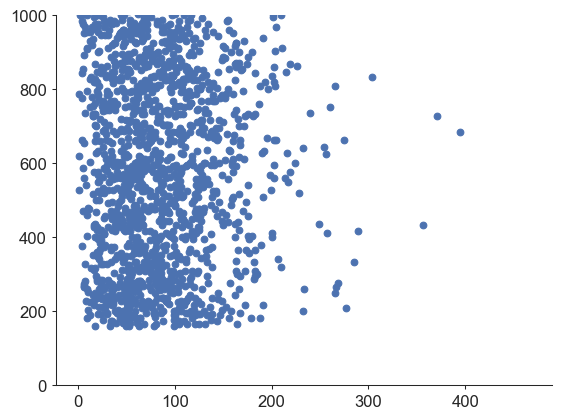

In [369]:
syn_mask = all_axo_syn.post_pt_root_id.isin(post_population_root_ids)
x = soma_soma_horiz_dist.values[syn_mask]
# x = np.round(x).astype(int)
y = all_axo_syn["size"].values[syn_mask]

def fit_fn(x, a, k, c):
    return a * np.exp(k * x) + c

def fit_exp_nonlinear(x, y):
    opt_params, _ = scipy.optimize.curve_fit(fit_fn, x, y, maxfev=1000)
    return opt_params

def fit_exp_linear(x, y, c=None):
    if c is None:
        if y.min() <= 0:
            c = y.min() - 20
        else:
            c = 0

    y = y - c
    y = np.log(y)
    k, log_a = np.polyfit(x, y, 1)
    a = np.exp(log_a)
    return a, k, c

init_guess = fit_exp_linear(x, y)
fit_params, _ = scipy.optimize.curve_fit(fit_fn, x, y, maxfev=2000, p0=init_guess)

plt.scatter(x, y)
plt.plot(dist_range, fit_fn(dist_range, *fit_params), color="blue", linewidth=4)
plt.ylim(0, 1000)

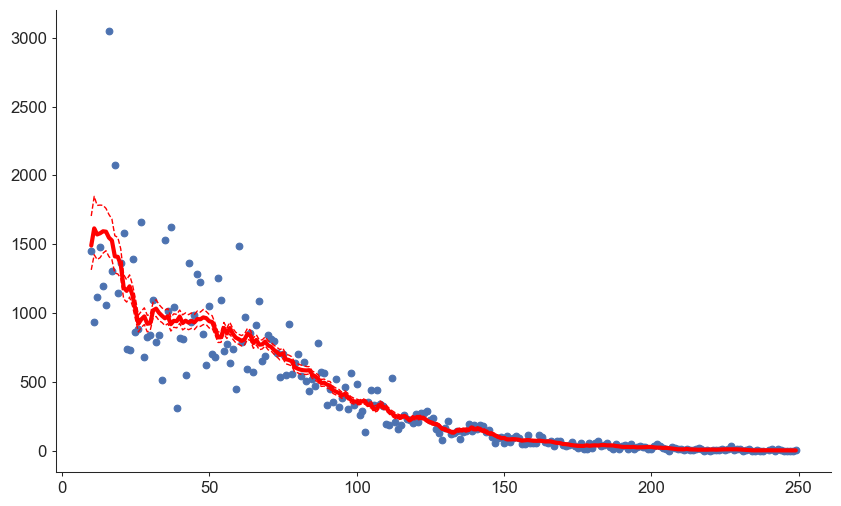

In [405]:
syn_mask = all_axo_syn.post_pt_root_id.isin(post_population_root_ids)
x = soma_soma_horiz_dist.values[syn_mask]
# x = np.round(x).astype(int)
y = all_axo_syn["size"].values[syn_mask]
x_unique = np.unique(x)

plt.figure(figsize=(10, 6))

r = 5
ci = 0.95
quantile_low = (1-confidence_interval) / 2

density = np.full_like(dist_range, np.nan, dtype=float)
density_ci = np.full((len(dist_range), 2), np.nan, dtype=float)

for dist_i, dist in enumerate(dist_range):
    mask = np.abs(x - dist) < r
    n_syn = int(mask.sum())

    if n_syn == 0:
        continue

    area = np.pi * ((dist+r)**2 - (dist-r)**2)
    y_pts = y[mask]

    den = y_pts.sum() / area
    density[dist_i] = den


    # boot_dist = y_pts[np.random.randint(low=0, high=n_syn, size=(n_boot, n_syn))].std(axis=1)
    # err = boot_dist.mean()

    boot_dist = y_pts[np.random.randint(low=0, high=n_syn, size=(n_boot, n_syn))].sum(axis=1)
    density_ci[dist_i, :] = np.quantile(boot_dist, (quantile_low, 1-quantile_low)) / area
    # density_ci[dist_i, :] = (den-err, den+err)



# plt.scatter(x, y)
plt.scatter(dist_range, syn_density_at_dist)
# plt.plot(dist_range, boot_dist.mean(axis=1), color="green")
plt.plot(dist_range, density, color="red", linewidth=3)
plt.plot(dist_range, density_ci[:, 0], color="red", linestyle="dashed", linewidth=1)
plt.plot(dist_range, density_ci[:, 1], color="red", linestyle="dashed", linewidth=1)
# plt.ylim(0, 5000)
# plt.xlim(0, 200)

In [394]:
density_ci.astype(int)

array([[549, 715],
       [623, 803],
       [599, 766],
       [615, 772],
       [656, 803],
       [680, 824],
       [628, 764],
       [627, 751],
       [541, 656],
       [562, 672],
       [534, 626],
       [425, 489],
       [410, 473],
       [431, 491],
       [389, 443],
       [318, 366],
       [262, 299],
       [271, 308],
       [280, 317],
       [249, 281],
       [249, 279],
       [298, 335],
       [302, 338],
       [286, 320],
       [272, 307],
       [264, 295],
       [274, 306],
       [243, 272],
       [253, 280],
       [249, 277],
       [273, 303],
       [245, 276],
       [251, 281],
       [243, 274],
       [252, 281],
       [246, 276],
       [255, 287],
       [259, 289],
       [270, 303],
       [274, 304],
       [259, 287],
       [256, 283],
       [233, 256],
       [203, 222],
       [202, 221],
       [230, 252],
       [212, 233],
       [228, 250],
       [207, 227],
       [193, 211],
       [188, 206],
       [180, 197],
       [182,

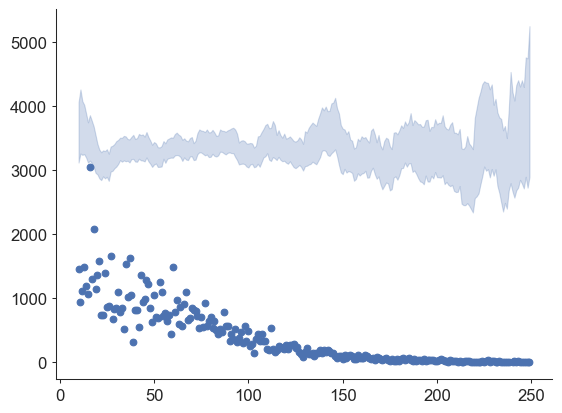

In [389]:
plt.scatter(dist_range, syn_density_at_dist)


# plt.ylim(0, 100)

# Confidence interval
ci_r = 5
boot_dist = np.full((len(dist_range), n_boot), np.nan, dtype=float)

for dist_i, dist in enumerate(dist_range):
    mask = np.abs(x - dist) < ci_r
    n_pts = int(mask.sum())

    if n_pts > 0:
        random_indices = np.random.randint(low=0, high=n_pts, size=(n_boot, n_pts))
        boot_dist[dist_i, :] = y[mask][random_indices].mean(axis=1)

quantile_low = (1-confidence_interval) / 2
boot_low, boot_high = np.quantile(boot_dist, (quantile_low, 1-quantile_low), axis=1)
plt.fill_between(dist_range, boot_low, boot_high, color="b", alpha=0.25)

In [290]:
plt.plot(y - C)

NameError: name 'C' is not defined

<Axes: >

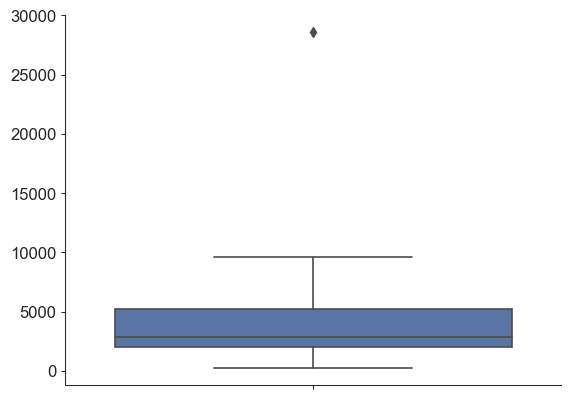

In [247]:
mask = all_axo_syn.post_pt_root_id.isin(post_population_root_ids)
x = soma_soma_horiz_dist[mask].values
y = all_axo_syn["size"].values[all_axo_syn.post_pt_root_id.isin(post_population_root_ids)]
# sns.regplot(x=x, y=y)

sns.boxplot(y=y[(8 < x) & (x < 10)])

In [223]:
boot_low

array([ 2626.08      ,  2591.534     ,  1846.66933333,  1790.88      ,
        1854.44133333,  1882.45466667,  1835.464     ,  1836.96533333,
        2251.164     ,   456.        ,   456.        ,   456.        ,
         456.        ,   456.        ,            nan,            nan,
        1088.        ,  7222.86      ,  7243.85146667,  7272.65306667,
        7239.41733333,  7223.71013333,  7254.17146667,  7261.71813333,
        7210.86986667,  6729.25835294,  6721.95129412,  6761.42447059,
        7069.41225   ,  4555.99288889,  4322.99768421,  4352.53536842,
        4289.09936842,  4334.48842105,  4335.69263158,  3994.88933333,
        3902.48345455,  4065.5952    ,  4049.2966    ,  4936.28      ,
        4374.82647059,  3969.63777778,  4238.92329412,  4257.128     ,
        3941.52947368,  3628.06609524,  3629.83695238,  3951.98147368,
        3331.87584   ,  3251.28177778,  3221.30733333,  2042.36033333,
        1822.1995    ,  1822.07425   ,  1824.3295    ,  1833.27825   ,
      

In [162]:
np.where([1, 2, np.nan, 4], np.isna)

AttributeError: module 'numpy' has no attribute 'isna'

TypeError: randint() got an unexpected keyword argument 'replace'

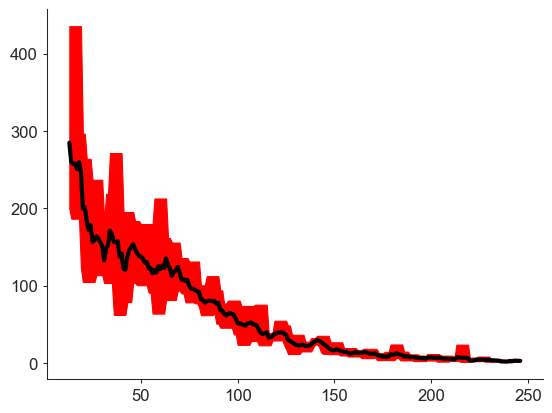

In [188]:
# syn_density_at_dist[20-rolling_avg_r:20+rolling_avg_r+1].flatten()



# boot_low_high = np.full((2, len()))
plt.plot(dist_range, y_rolling_avg, color="black", linewidth=3)
plt.fill_between(dist_range, boot_high, boot_low, color="red")

In [185]:
boot_low

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na